In [1]:
import os
import pathlib
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import librosa
import librosa.display
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# to play the audios
import IPython.display as ipd

from sklearn.model_selection import train_test_split

In [2]:
# listing all the audio files with wav format in subfolders of 'data' folder
files_path = glob('../data/*/*.wav')
files_path

['../data/happy/03-01-03-01-01-02-06.wav',
 '../data/happy/03-01-03-01-01-02-12.wav',
 '../data/happy/03-01-03-02-02-02-12.wav',
 '../data/happy/03-01-03-02-02-02-06.wav',
 '../data/happy/03-01-03-02-02-02-07.wav',
 '../data/happy/03-01-03-02-02-02-13.wav',
 '../data/happy/03-01-03-01-01-02-13.wav',
 '../data/happy/03-01-03-01-01-02-07.wav',
 '../data/happy/03-01-03-01-01-02-11.wav',
 '../data/happy/03-01-03-01-01-02-05.wav',
 '../data/happy/03-01-03-02-02-02-05.wav',
 '../data/happy/03-01-03-02-02-02-11.wav',
 '../data/happy/03-01-03-01-02-02-19.wav',
 '../data/happy/03-01-03-02-01-02-19.wav',
 '../data/happy/03-01-03-02-01-02-24.wav',
 '../data/happy/03-01-03-02-01-02-18.wav',
 '../data/happy/03-01-03-01-02-02-18.wav',
 '../data/happy/03-01-03-01-02-02-24.wav',
 '../data/happy/03-01-03-02-02-02-10.wav',
 '../data/happy/03-01-03-02-02-02-04.wav',
 '../data/happy/03-01-03-01-01-02-04.wav',
 '../data/happy/03-01-03-01-01-02-10.wav',
 '../data/happy/03-01-03-01-01-02-14.wav',
 '../data/h

In [3]:
# reading and extracting characteristics of the files
files = []
lengths = []
seconds = []
labels = []
emotions = []
sample_rate = []
corrupted_files = []
len_trim = []
np_max = []

for file in files_path:
  try:
    # extracting filepath
    files.append(file)
    # loading audio using librosa
    y, sr = librosa.load(file)
    # extracting numpy array length of the file
    lengths.append(len(y))
    # extracting how many seconds the file has
    seconds.append(len(y)/sr)
    # extracting sample rate to check if all audios have the same sample rate
    sample_rate.append(sr)
    # extracting the label as string and as integer
    labels.append(file.split('-')[-5])
    emotions.append(file.split('/')[2])
    # setting a threshold of 30 below reference to be considered as silence
    y_trimmed, _ = librosa.effects.trim(y, top_db = 30)
    #appending the trimmed audio
    len_trim.append(len(y_trimmed))
    # getting the highest amplitude of the file
    np_max.append(np.max(y))
  except:
    # checking if files could not be open with librosa
    corrupted_files.append(file)

In [4]:
# creating a dataset with those extracted features
files_details = pd.DataFrame([files, lengths, seconds, sample_rate, emotions, labels, len_trim, np_max]).T
files_details.columns = ['file', 'length', 'seconds', 'sample_rate', 'emotions', 'label', 'len_trim', 'max_amp']
files_details['label'] = files_details['label'].astype(int)
files_details['label'] = files_details['label']-1

In [5]:
files_details.head()

,file,length,seconds,sample_rate,emotions,label,len_trim,max_amp
0,../data/happy/03-01-03-01-01-02-06.wav,79460,3.603628,22050,happy,2,43008,0.080685
1,../data/happy/03-01-03-01-01-02-12.wav,82403,3.737098,22050,happy,2,39424,0.082316
2,../data/happy/03-01-03-02-02-02-12.wav,87553,3.970658,22050,happy,2,44032,0.438894
3,../data/happy/03-01-03-02-02-02-06.wav,79460,3.603628,22050,happy,2,38400,0.350624
4,../data/happy/03-01-03-02-02-02-07.wav,84610,3.837188,22050,happy,2,50176,0.263731


In [6]:
# exporting the dataframe created as csv
files_details.to_csv('../csvs/files_details.csv')

In [7]:
print(f'Minimum amplitude of the dataset: {files_details["max_amp"].min()}')
print(f'Maximum amplitude of the dataset: {files_details["max_amp"].max()}')

Minimum amplitude of the dataset: 0.0040511623956263065
Maximum amplitude of the dataset: 1.0088781118392944


> Amplitude represents the loudness of the sound. We can see that there are great differences in that in the dataset. It is necessary to normalize these values to input to the model.

In [8]:
files_details['emotions'].value_counts()

happy        192
sad          192
calm         192
fearful      192
angry        192
surprised    192
disgust      192
neutral       96
Name: emotions, dtype: int64

In [9]:
files_details['emotions'].value_counts(normalize = True)

happy        0.133333
sad          0.133333
calm         0.133333
fearful      0.133333
angry        0.133333
surprised    0.133333
disgust      0.133333
neutral      0.066667
Name: emotions, dtype: float64

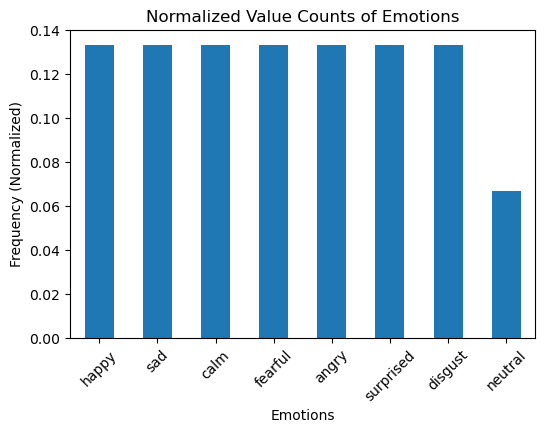

In [10]:
value_counts_normalized = files_details['emotions'].value_counts(normalize=True)

# Create a bar plot
plt.figure(figsize=(6, 4))
value_counts_normalized.plot(kind='bar')
plt.xlabel('Emotions')
plt.ylabel('Frequency (Normalized)')
plt.title('Normalized Value Counts of Emotions')
plt.xticks(rotation=45);  # Rotate x-axis labels for better visibility

> We can see that the target variables are not balanced in this dataset. We may improve that with audio augmentation (some strategies are adding noise, shifting the audio in time, changing the pitch)
<br> As it is, the baseline is 13.3%.

In [11]:
print(f'Maximum seconds: {round(files_details["seconds"].max(),2)}')
print(f'Minimum seconds: {round(files_details["seconds"].min(), 2)}')

Maximum seconds: 5.27
Minimum seconds: 2.94


> Files have different lengths in this dataset. To input to the model, they have to have the same shape. This can be done by setting the numpy array loaded in librosa to some predefined size. Audios longer than the predefined size will be cut and shorter ones will be padded with zeros (silence).

Below, it is possible to see how the data changes along the different steps of manipulation. First, the file is loaded as a numpy array. Then, the numpy array is trimmed based in a db reference to consider as silence. After that, to reach the target size all files must have to be inputted to the model, if the array is longer than the target size it is cut and, if it is shorter, it is padded in the extremes with zero (that is, silence). <br><br>
After this preprocess of the audio as numpy array, it is transformed to a melspectrogram. This is considered as the image of the audio, it shows the strengths of the different frequencies along time. For the model, all spectrograms of the training set will compose the statistics to normalize the values of all the spectrograms - this will be the normalization of the whole model, used when testing and making classifications.

In [12]:
# loading and trimming audio
y, sr = librosa.load(files_path[0])
print(f'Audio first loaded, shape: {y.shape}')
y_trimmed, _ = librosa.effects.trim(y, top_db = 30) # trim based on a db reference
print(f'Audio trimmed, shape: {y_trimmed.shape}')

# setting the same length
target_size = 88200
if len(y_trimmed) > target_size:
    y_trimmed = y_trimmed[:target_size]
elif len(y_trimmed) < target_size:
    y_trimmed = librosa.util.pad_center(y_trimmed, size=target_size, axis=0) # 88200 is 4s of audio, at sample rate 22050
print(f'Trimmed audio padded with zeros to reach target size: {y_trimmed.shape}')

# getting melspectrogram of trimmed audio
S = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels = 128)
S_db_mel = librosa.amplitude_to_db(S, ref = np.max)
print(f'Melpectogram of preprocessed audio, shape: {S_db_mel.shape}')

Audio first loaded, shape: (79460,)
Audio trimmed, shape: (43008,)
Trimmed audio padded with zeros to reach target size: (88200,)
Melpectogram of preprocessed audio, shape: (128, 173)


## Longest Angry

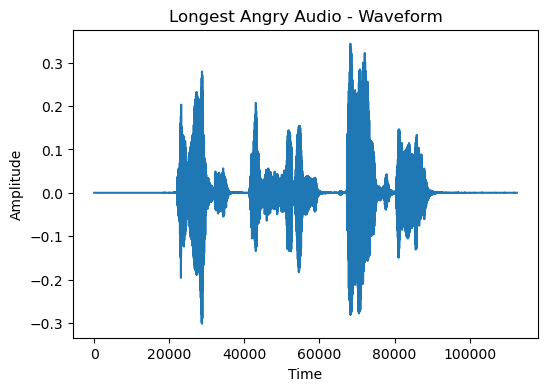

In [51]:
long_angry = files_details[files_details['emotions']=='angry'].sort_values('seconds', ascending = False).iloc[0]['file']
y, sr = librosa.load(long_angry)
plt.figure(figsize=(6, 4))
plt.title('Longest Angry Audio - Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(y)
ipd.Audio(long_angry)

In [48]:
print(len(y))

116247


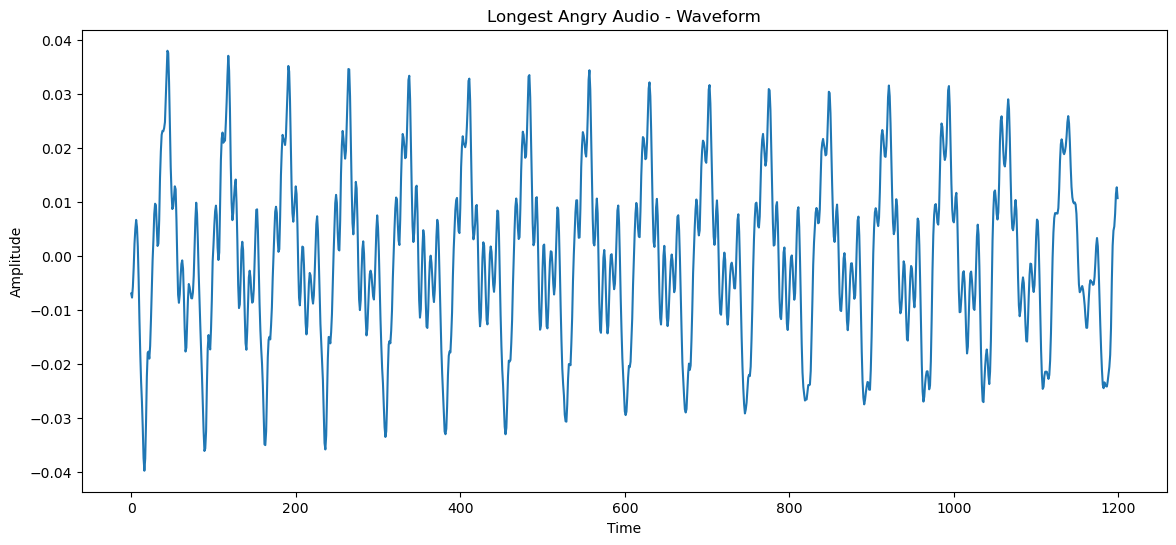

In [55]:
plt.figure(figsize=(14, 6))
plt.title('Longest Angry Audio - Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(y[57000:58200])

## Longest Angry Trimmed

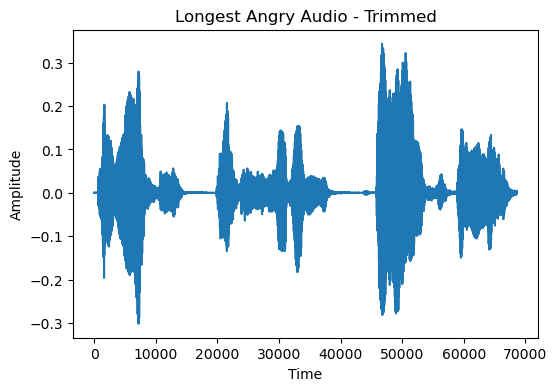

In [14]:
long_angry = files_details[files_details['emotions']=='angry'].sort_values('seconds', ascending = False).iloc[0]['file']
y, sr = librosa.load(long_angry)
y_trimmed, _ = librosa.effects.trim(y, top_db = 30)
plt.figure(figsize=(6, 4))
plt.title('Longest Angry Audio - Trimmed')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(y_trimmed)
ipd.Audio(y_trimmed, rate=22050)

## Longest Angry Trimmed Spectrogram

In [31]:
long_angry = files_details[files_details['emotions']=='angry'].sort_values('seconds', ascending = False).iloc[0]['file']
ipd.Audio(long_angry)

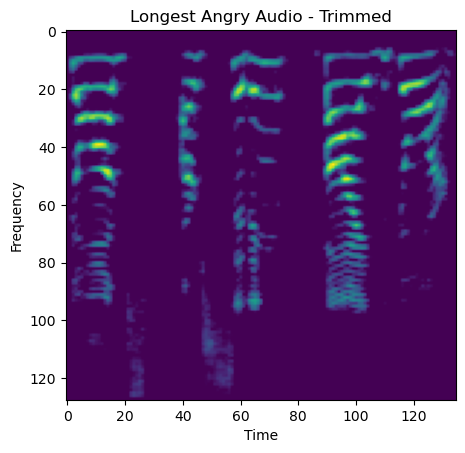

In [28]:
long_angry = files_details[files_details['emotions']=='angry'].sort_values('seconds', ascending = False).iloc[0]['file']
y, sr = librosa.load(long_angry)
y_trimmed, _ = librosa.effects.trim(y, top_db = 30)
# getting melspectrogram of trimmed audio
S = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels = 128)
S_db_mel = librosa.amplitude_to_db(S, ref = np.max)
plt.title('Longest Angry Audio - Trimmed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.imshow(S_db_mel);

## Longest Audio

In [30]:
ipd.Audio('../data/disgust/03-01-07-02-01-02-19.wav')

In [16]:
files_details[files_details['len_trim']==93696].iloc[0]['file']

1345    ../data/disgust/03-01-07-02-01-02-19.wav
Name: file, dtype: object

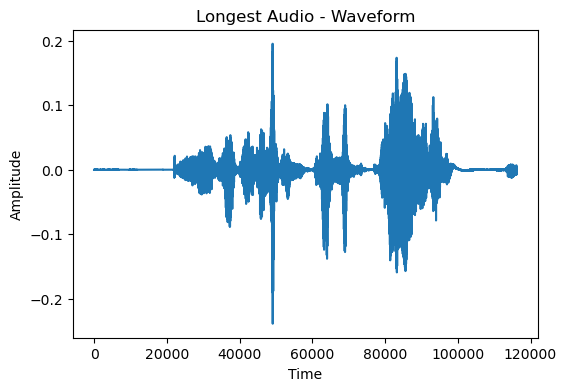

In [61]:
# loading and trimming audio
y, sr = librosa.load('../data/disgust/03-01-07-02-01-02-19.wav')

plt.figure(figsize=(6, 4))
plt.title('Longest Audio - Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(y);

Audio first loaded, shape: (116247,)
Audio trimmed, shape: (93696,)
Trimmed audio padded with zeros to reach target size: (88200,)


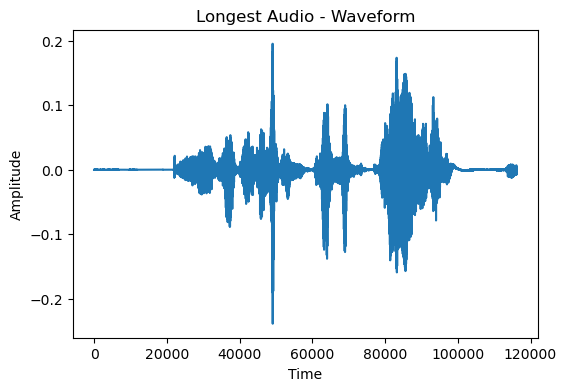

In [60]:
# loading and trimming audio
y, sr = librosa.load('../data/disgust/03-01-07-02-01-02-19.wav')
print(f'Audio first loaded, shape: {y.shape}')
y_trimmed, _ = librosa.effects.trim(y, top_db = 30) # trim based on a db reference
print(f'Audio trimmed, shape: {y_trimmed.shape}')

# setting the same length
target_size = 88200
if len(y_trimmed) > target_size:
    y_trimmed = y_trimmed[:target_size]
elif len(y_trimmed) < target_size:
    y_trimmed = librosa.util.pad_center(y_trimmed, size=target_size, axis=0) # 88200 is 4s of audio, at sample rate 22050
print(f'Trimmed audio padded with zeros to reach target size: {y_trimmed.shape}')

plt.figure(figsize=(6, 4))
plt.title('Longest Audio - Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(y);

Audio first loaded, shape: (116247,)
Audio trimmed, shape: (93696,)
Trimmed audio padded with zeros to reach target size: (88200,)


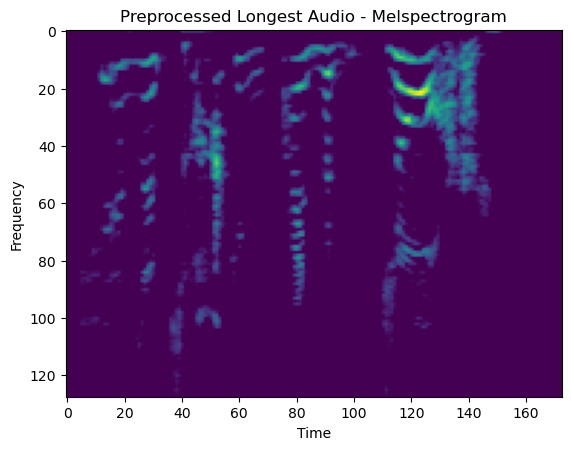

In [58]:
# loading and trimming audio
y, sr = librosa.load('../data/disgust/03-01-07-02-01-02-19.wav')
print(f'Audio first loaded, shape: {y.shape}')
y_trimmed, _ = librosa.effects.trim(y, top_db = 30) # trim based on a db reference
print(f'Audio trimmed, shape: {y_trimmed.shape}')

# setting the same length
target_size = 88200
if len(y_trimmed) > target_size:
    y_trimmed = y_trimmed[:target_size]
elif len(y_trimmed) < target_size:
    y_trimmed = librosa.util.pad_center(y_trimmed, size=target_size, axis=0) # 88200 is 4s of audio, at sample rate 22050
print(f'Trimmed audio padded with zeros to reach target size: {y_trimmed.shape}')

# getting melspectrogram of trimmed audio
S = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels = 128)
S_db_mel = librosa.amplitude_to_db(S, ref = np.max)
plt.title('Preprocessed Longest Audio - Melspectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.imshow(S_db_mel);

## Shortest Audio

In [24]:
files_details[files_details['seconds']==files_details['seconds'].min()]['file']

506    ../data/calm/03-01-02-01-02-02-13.wav
Name: file, dtype: object

In [37]:
# playing shortest audio
ipd.Audio('../data/calm/03-01-02-01-02-02-13.wav')

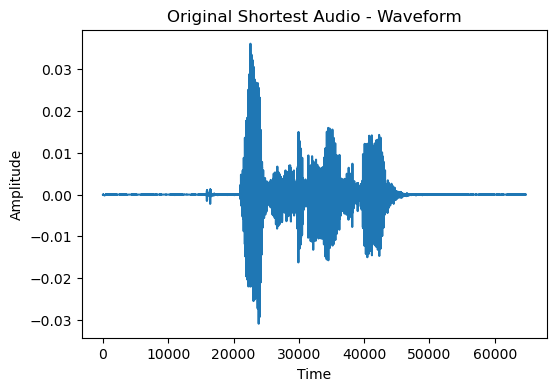

In [59]:
# Waveform of preprocessed shortest audio
y, sr = librosa.load('../data/calm/03-01-02-01-02-02-13.wav')

plt.figure(figsize=(6, 4))
plt.title('Original Shortest Audio - Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(y)

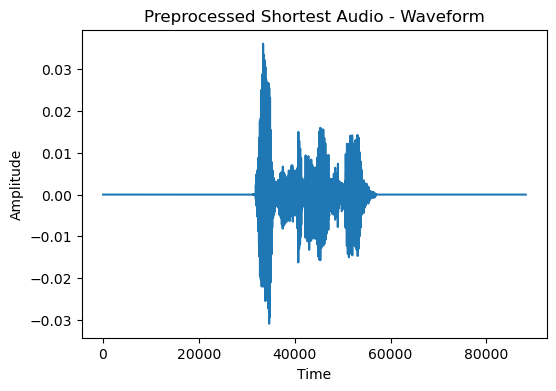

In [39]:
# Waveform of preprocessed shortest audio
y, sr = librosa.load('../data/calm/03-01-02-01-02-02-13.wav')
y_trimmed, _ = librosa.effects.trim(y, top_db = 30)
# setting the same length
target_size = 88200
if len(y_trimmed) > target_size:
    y_trimmed = y_trimmed[:target_size]
elif len(y_trimmed) < target_size:
    y_trimmed = librosa.util.pad_center(y_trimmed, size=target_size, axis=0) # 88200 is 4s of audio, at sample rate 22050

plt.figure(figsize=(6, 4))
plt.title('Preprocessed Shortest Audio - Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(y_trimmed)
ipd.Audio(y_trimmed, rate=22050)

Audio first loaded, shape: (64745,)
Audio trimmed, shape: (25600,)
Trimmed audio padded with zeros to reach target size: (88200,)


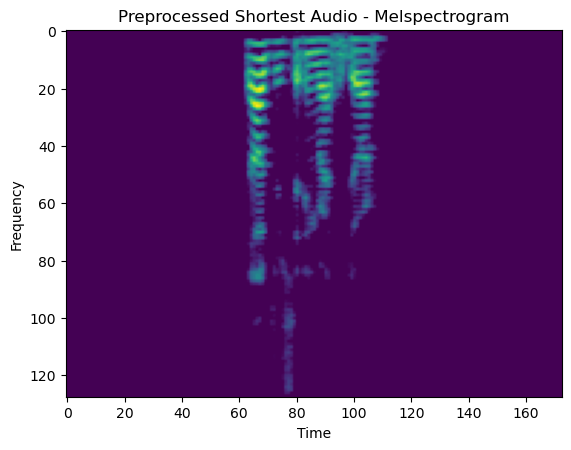

In [41]:
# loading and trimming audio
y, sr = librosa.load('../data/calm/03-01-02-01-02-02-13.wav')
print(f'Audio first loaded, shape: {y.shape}')
y_trimmed, _ = librosa.effects.trim(y, top_db = 30) # trim based on a db reference
print(f'Audio trimmed, shape: {y_trimmed.shape}')

# setting the same length
target_size = 88200
if len(y_trimmed) > target_size:
    y_trimmed = y_trimmed[:target_size]
elif len(y_trimmed) < target_size:
    y_trimmed = librosa.util.pad_center(y_trimmed, size=target_size, axis=0) # 88200 is 4s of audio, at sample rate 22050
print(f'Trimmed audio padded with zeros to reach target size: {y_trimmed.shape}')

# getting melspectrogram of trimmed audio
S = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels = 128)
S_db_mel = librosa.amplitude_to_db(S, ref = np.max)
plt.title('Preprocessed Shortest Audio - Melspectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.imshow(S_db_mel);

References:
<Br> <br>
- Ketan Doshi article in Medium: https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504
- Rob Mulla's Audio Processing in Python tutorial on youtube: https://youtu.be/ZqpSb5p1xQo
- Librosa Documentation